# Выполнила Вероника Зыкова, БКЛ192

В отдельном файле, так как в самом файле домашки очень много всего и мне стало неудобно. Но там, если что, тоже все это есть, просто не в классе, а в функции, как был шаблон в задании.

# Imports

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

# Data read and transform

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

# Get data loaders

In [4]:
#фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3 или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
#тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
#необходимы препроцессинг лейблов, видимо не все значения имею тип integer, а нам нужен именно этот тип функция лонг позволяет нам 
#        это сделать (self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# My perceptron realisation

In [6]:
class MyPerceptron:
    def __init__(self, lr=0.01,  insize=784, hidsize=256, outsize=1):
        self.learning_rate = lr

        self.input_size = insize
        self.hidden_size = hidsize
        self.output_size = outsize

        self.w1 = np.random.rand(self.input_size, self.hidden_size) * 0.01
        self.b1 = np.zeros(1)
        self.w2 = np.random.rand(self.hidden_size, self.output_size) * 0.01
        self.b2 = np.zeros(1)

        self.train_losses = []

    def train(self, train_loader, epochs=5):
        batch_size = train_loader.batch_size
        for n_epoch in range(epochs):

            print(f'Epoch: {n_epoch + 1}')

            for x, y in tqdm(train_loader):
                
                x = x.view(x.shape[0], -1).numpy()
                y = np.expand_dims(y.numpy(), 1)

                # forward
                z1 = x.dot(self.w1) + self.b1
                a1 = 1 / (1 + np.exp(-z1))
                z2 = z1.dot(self.w2) + self.b2
                p = 1 / (1 + np.exp(-z2))

                # рассчет bce
                bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
                self.train_losses.append(bce)

                # backward
                dbce = - y / p + (1 - y) / (1 - p)
                dpred = dbce * (1 - p) * p
                dz2 = np.dot(dpred, self.w2.T)
                dw2 = np.dot(a1.T, dpred) / batch_size
                db2 = np.sum(dpred)

                da1 = dz2 * (1 - a1) * a1 / batch_size
                dw1 = np.dot(x.T, da1)
                db1 = np.sum(da1)

                # gradient descent
                self.w2 -= self.learning_rate * dw2
                self.b2 -= self.learning_rate * db2
                self.w1 -= self.learning_rate * dw1
                self.b1 -= self.learning_rate * db1

    def evaluate(self, train_loader):
        losses_test = []
        predicted = []
        true_lbls = []

        batch_size = train_loader.batch_size
        for x, y in tqdm(train_loader):
                
            x = x.view(x.shape[0], -1).numpy()
            y = np.expand_dims(y.numpy(), 1)
            
            # forward
            z1 = x.dot(self.w1) + self.b1
            a1 = 1 / (1 + np.exp(-z1))
            z2 = z1.dot(self.w2) + self.b2
            p = 1 / (1 + np.exp(-z2))

            # рассчет bce
            bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
            
            losses_test.append(bce)
            predicted.extend(p)
            true_lbls.extend(y) 
        return true_lbls, predicted, losses_test

# Train

In [7]:
myperceptron = MyPerceptron(lr=0.01,  insize=784, hidsize=256, outsize=1)
myperceptron.train(train_loader, 10)

Epoch: 1


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/97 [00:00<?, ?it/s]

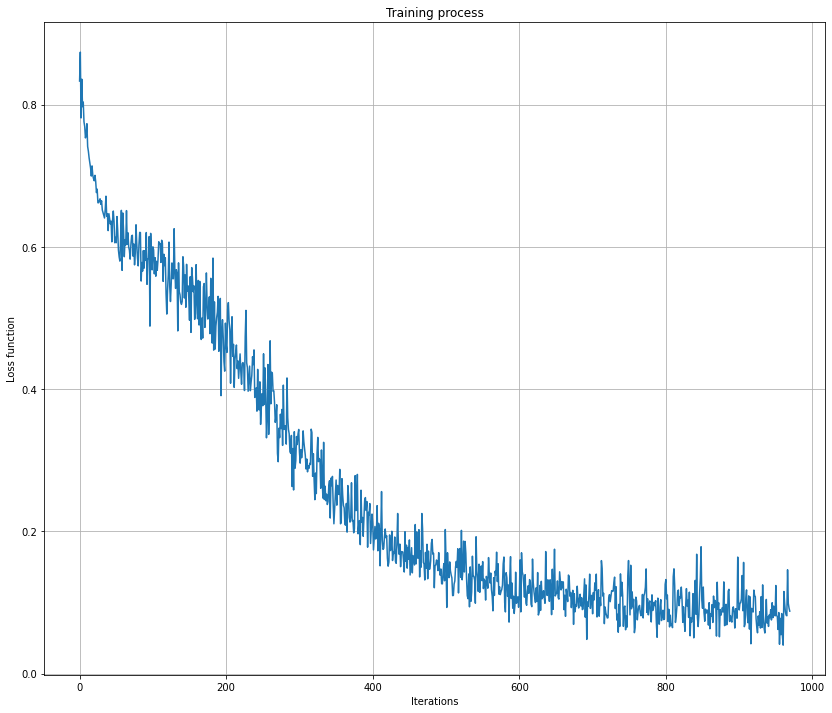

In [8]:
plt.figure(figsize=(14, 12))
plt.plot(myperceptron.train_losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.show()

# Evaluate

In [9]:
true_lbls, predicted, losses_test = myperceptron.evaluate(train_loader)
pred = np.array([round(i[0]) for i in predicted]) 
t_lbls = np.array(true_lbls).squeeze()
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

  0%|          | 0/97 [00:00<?, ?it/s]

F1 score is equal to: 0.97
